In [10]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('states.csv', 'states'),
    ('partywise_results.csv', 'partywise_results'),
    ('constituencywise_results.csv', 'constituencywise_results'),
    ('constituencywise_details.csv', 'constituencywise_details'),
    ('statewise_results.csv', 'statewise_results') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='workhard12!@',
    database='LokSabhaResult'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/kartikpatidar/Downloads/Work/SQL projects/election2024'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing states.csv
NaN values before replacement:
State ID    0
State       0
dtype: int64

Processing partywise_results.csv
NaN values before replacement:
Party       0
Won         0
Party ID    0
dtype: int64

Processing constituencywise_results.csv
NaN values before replacement:
S.No                       0
Parliament Constituency    0
Constituency Name          0
Winning Candidate          0
Total Votes                0
Margin                     0
Constituency ID            0
Party ID                   0
dtype: int64

Processing constituencywise_details.csv
NaN values before replacement:
S.N.               0
Candidate          0
Party              0
EVM Votes          0
Postal Votes       0
Total Votes        0
% of Votes         0
Constituency ID    0
dtype: int64

Processing statewise_results.csv
NaN values before replacement:
Constituency               0
Const. No.                 0
Parliament Constituency    0
Leading Candidate          0
Trailing Candidate         1
Margin

In [1]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='workhard12!@',
    database='LokSabhaResult'
)

cur = db.cursor()

# Total Seats on which election was held.

In [4]:
query = """ select distinct count(Parliament_Constituency)
from constituencywise_results; """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["total number of seats"])
df.head()

,total number of seats
0,543


# What is the total number of seats available for elections in each state.


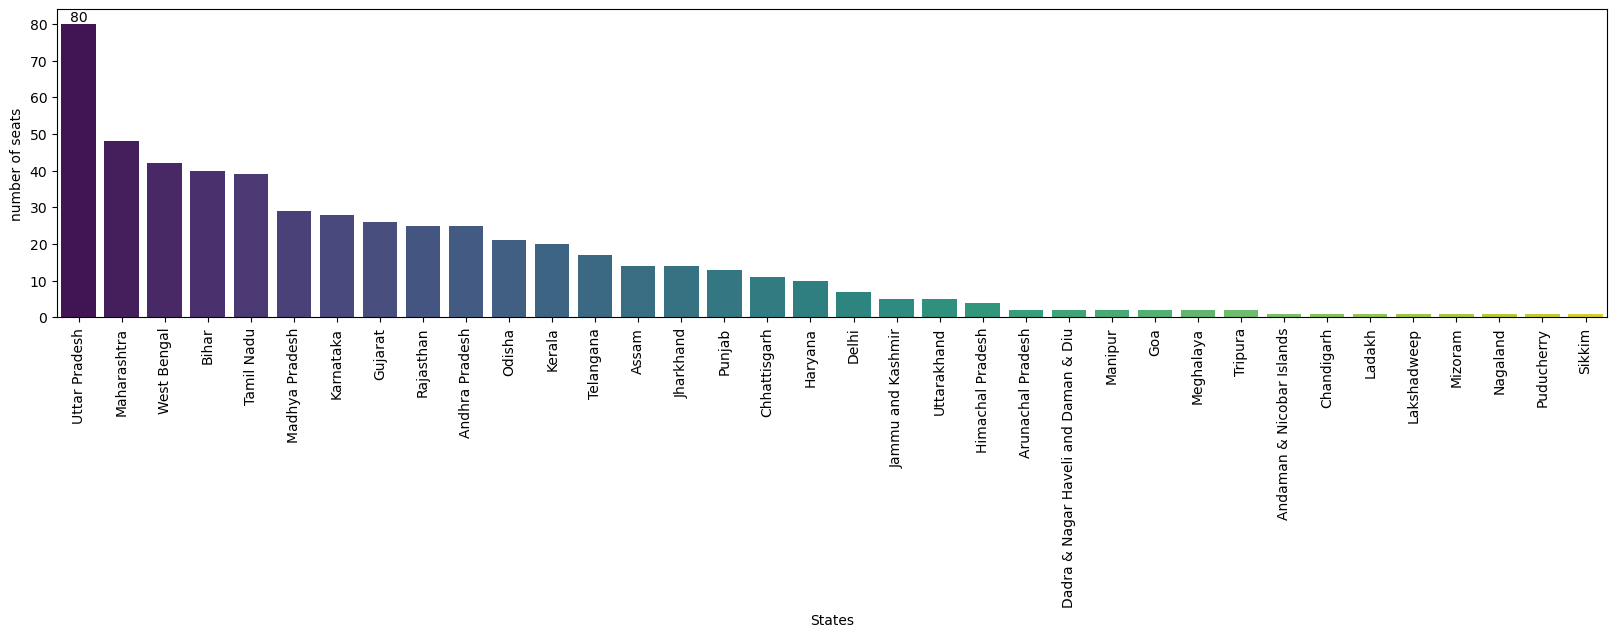

In [37]:
query = """ select s.state,count(cr.Constituency_ID)
from constituencywise_results as cr join statewise_results as sr
on cr.Parliament_Constituency = sr.Parliament_Constituency
join 
states as s 
on s.State_ID = sr.State_ID
group by s.state
order by count(cr.Constituency_ID) desc;"""
cur.execute(query)
data = cur.fetchall()
plt.figure(figsize=(20, 4))
df = pd.DataFrame(data,columns = ["States","number of seats"])
ax = sns.barplot(x="States", y= "number of seats" ,data=df,palette='viridis',hue='States')
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.show()

# Total Seats Won by NDA Allianz

In [11]:
query = """ select 
       sum(case
         when Party in ('Bharatiya Janata Party - BJP', 
                'Telugu Desam - TDP', 
				'Janata Dal  (United) - JD(U)',
                'Shiv Sena - SHS', 
                'AJSU Party - AJSUP', 
                'Apna Dal (Soneylal) - ADAL', 
                'Asom Gana Parishad - AGP',
                'Hindustani Awam Morcha (Secular) - HAMS', 
                'Janasena Party - JnP', 
				'Janata Dal  (Secular) - JD(S)',
                'Lok Janshakti Party(Ram Vilas) - LJPRV', 
                'Nationalist Congress Party - NCP',
                'Rashtriya Lok Dal - RLD', 
                'Sikkim Krantikari Morcha - SKM' 
                )THEN Won
                Else 0
                END)
                FROM partywise_results"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["number of seats"])
df

,number of seats
0,292


# Seats Won by NDA Allianz Parties.

In [26]:
query = """ select Party,Won
from partywise_results
where Party_alliance = "NDA"
order by Won desc;;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Party","number of seats"])
df

,Party,number of seats
0,Bharatiya Janata Party - BJP,240
1,Telugu Desam - TDP,16
2,Janata Dal (United) - JD(U),12
3,Shiv Sena - SHS,7
4,Lok Janshakti Party(Ram Vilas) - LJPRV,5
5,Janasena Party - JnP,2
6,Janata Dal (Secular) - JD(S),2
7,Rashtriya Lok Dal - RLD,2
8,AJSU Party - AJSUP,1
9,Apna Dal (Soneylal) - ADAL,1


# Total Seats Won by I.N.D.I.A. Allianz.





In [12]:
query = """ select sum(Won)
from partywise_results
where Party_alliance = "I.N.D.I.A"
order by Won desc;;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["number of seats"])
df

,number of seats
0,234


# Seats Won by I.N.D.I.A. Allianz Parties.


In [3]:
query = """ select Party,Won
from partywise_results
where Party_alliance = "I.N.D.I.A"
order by Won desc;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Party","number of seats"])
df

,Party,number of seats
0,Indian National Congress - INC,99
1,Samajwadi Party - SP,37
2,All India Trinamool Congress - AITC,29
3,Dravida Munnetra Kazhagam - DMK,22
4,Shiv Sena (Uddhav Balasaheb Thackrey) - SHSUBT,9
5,Nationalist Congress Party Sharadchandra Pawar...,8
6,Communist Party of India (Marxist) - CPI(M),4
7,Rashtriya Janata Dal - RJD,4
8,Aam Aadmi Party - AAAP,3
9,Indian Union Muslim League - IUML,3


# Winning candidate's name, their party name, total votes, and the margin of victory for a specific state and constituency?


In [5]:
query = """ select cr.Winning_Candidate,pr.Party,cr.Total_Votes,cr.Margin,s.State,cr.Constituency_Name
from constituencywise_results as cr
 join partywise_results as pr
 on cr.Party_ID = pr.Party_ID
 join statewise_results as sr
 on cr.Parliament_Constituency = sr.Parliament_Constituency
 join states as s
 on s.State_ID = sr.State_ID
WHERE s.State = "Madhya Pradesh" and cr.Constituency_Name = "INDORE";"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Winning Cndidate","Party","Total votes","Margin of votes","State","Constituency"])
df

,Winning Cndidate,Party,Total votes,Margin of votes,State,Constituency
0,SHANKAR LALWANI,Bharatiya Janata Party - BJP,1226751,1175092,Madhya Pradesh,INDORE


# What is the distribution of EVM votes versus postal votes for candidates in a specific constituency.

In [8]:
query = """ SELECT 
    cd.Candidate,
    cd.Party,
    cd.EVM_Votes,
    cd.Postal_Votes,
    cd.Total_Votes,
    cr.Constituency_Name
FROM 
    constituencywise_details cd
JOIN 
    constituencywise_results cr ON cd.Constituency_ID = cr.Constituency_ID
WHERE 
    cr.Constituency_Name = 'RATLAM'
ORDER BY cd.Total_Votes DESC;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Candidate","Party","EVM votes","Postal Votes","Total votes","Constituency"])
df

,Candidate,Party,EVM votes,Postal Votes,Total votes,Constituency
0,ANITA NAGARSINGH CHOUHAN,Bharatiya Janata Party,793432,2431,795863,RATLAM
1,KANTILAL BHURIA,Indian National Congress,586904,1727,588631,RATLAM
2,ENGINEER BALUSINGH GAMAD,Bharat Adivasi Party,52525,234,52759,RATLAM
3,NOTA,None of the Above,31697,38,31735,RATLAM
4,RAMCHANDRA SOLANKI,Bahujan Samaj Party,15159,13,15172,RATLAM
5,SURAJ BHABHAR,Independent,10060,2,10062,RATLAM
6,RANGLA KALESH,Independent,7331,4,7335,RATLAM
7,KASNA RANA PARGI,Independent,7311,5,7316,RATLAM
8,SUMITRA MEDA,Independent,6927,3,6930,RATLAM
9,RAMESHWAR SINGAR,Independent,4603,4,4607,RATLAM


# Which parties won the most seats in s State, and how many seats did each party win?


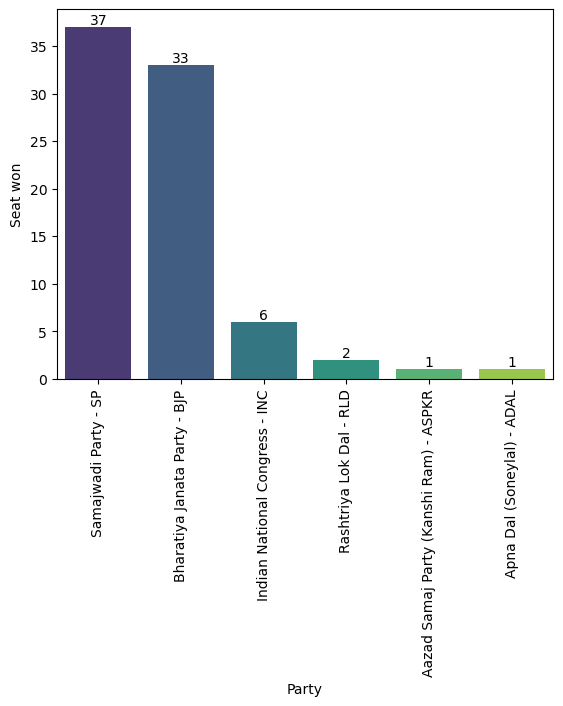

In [44]:
query = """select pr.Party,count(cr.Constituency_Name) as Seat_won
from constituencywise_results as cr
 join partywise_results as pr
 on cr.Party_ID = pr.Party_ID
 join statewise_results as sr
 on cr.Parliament_Constituency = sr.Parliament_Constituency
 join states as s
 on s.State_ID = sr.State_ID
WHERE s.State = "UTTAR PRADESH"
group by pr.Party
order by Seat_won desc;"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Party","Seat won"])
ax = sns.barplot(x="Party", y= "Seat won" ,data=df,palette='viridis',hue='Party')
plt.xticks(rotation = 90)
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom')

plt.show()

# What is the total number of seats won by each party alliance (NDA, I.N.D.I.A, and OTHER) in each state for the India Elections 2024


In [13]:
query = """select s.State,
SUM(case when pr.Party_alliance = "NDA" Then 1 Else 0 End) as NDA_seats_won,
SUM(case when pr.Party_alliance = "I.N.D.I.A" Then 1 Else 0 End) as INDIA_seats_won,
SUM(case when pr.Party_alliance = "OTHER" Then 1 Else 0 End) as Other_seats_won

from constituencywise_results as cr
 join partywise_results as pr
 on cr.Party_ID = pr.Party_ID
 join statewise_results as sr
 on cr.Parliament_Constituency = sr.Parliament_Constituency
 join states as s
 on s.State_ID = sr.State_ID
 where pr.Party_alliance in ('NDA','I.N.D.I.A','OTHER')
 group by s.State
 order by s.State;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns= ["Party","NDA seats won","INDIA seats won","Others seat won"])
df

,Party,NDA seats won,INDIA seats won,Others seat won
0,Andaman & Nicobar Islands,1,0,0
1,Andhra Pradesh,21,0,4
2,Arunachal Pradesh,2,0,0
3,Assam,10,3,1
4,Bihar,30,9,1
5,Chandigarh,0,1,0
6,Chhattisgarh,10,1,0
7,Dadra & Nagar Haveli and Daman & Diu,1,0,1
8,Delhi,7,0,0
9,Goa,1,1,0


# Which candidate received the highest number of EVM votes in each constituency (Top 10)

In [3]:
query = """select cr.Constituency_Name,cr.Constituency_ID,cd.Candidate,cd.EVM_Votes
from constituencywise_details as cd join constituencywise_results as cr
on cd.Constituency_ID = cr.Constituency_ID
where 
cd.EVM_Votes = (select max(cd1.EVM_Votes)
                from constituencywise_details as cd1
                where cd.Constituency_ID = cd1.Constituency_ID)
order by cd.EVM_Votes desc;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Constituency Name","Constituency_ID","Candidate","EVM_Votes"])
df

,Constituency Name,Constituency_ID,Candidate,EVM_Votes
0,DHUBRI,S032,RAKIBUL HUSSAIN,1468549
1,INDORE,S1226,SHANKAR LALWANI,1223746
2,VIDISHA,S1218,SHIVRAJ SINGH CHOUHAN,1111556
3,BANGALORERURAL,S1023,DR C N MANJUNATH,1075553
4,RAIPUR,S268,BRIJMOHAN AGRAWAL,1047447
...,...,...,...,...
538,ANDAMAN&NICOBARISLANDS,U011,BISHNU PADA RAY,102182
539,LADAKH,U091,MOHMAD HANEEFA,64443
540,DAMAN&DIU,U031,PATEL UMESHBHAI BABUBHAI,42469
541,LAKSHADWEEP,U061,MUHAMMED HAMDULLAH SAYEED,25405


# Which candidate won and which candidate was the runner-up in each constituency of State for the 2024 elections?


In [28]:
query = """WITH RankedCandidates AS (
    SELECT 
        cd.Constituency_ID,
        cd.Candidate,
        cd.Party,
        cd.EVM_Votes,
        cd.Postal_Votes,
        cd.EVM_Votes + cd.Postal_Votes AS Total_Votes,
        ROW_NUMBER() OVER (PARTITION BY cd.Constituency_ID ORDER BY cd.EVM_Votes + cd.Postal_Votes DESC) AS VoteRank
    FROM 
        constituencywise_details cd
    JOIN 
        constituencywise_results cr ON cd.Constituency_ID = cr.Constituency_ID
    JOIN 
        statewise_results sr ON cr.Parliament_Constituency = sr.Parliament_Constituency
    JOIN 
        states s ON sr.State_ID = s.State_ID
    WHERE 
        s.State = 'Maharashtra'
)

SELECT 
    cr.Constituency_Name,
    MAX(CASE WHEN rc.VoteRank = 1 THEN rc.Candidate END) AS Winning_Candidate,
    MAX(CASE WHEN rc.VoteRank = 2 THEN rc.Candidate END) AS Runnerup_Candidate
FROM 
    RankedCandidates rc
JOIN 
    constituencywise_results cr ON rc.Constituency_ID = cr.Constituency_ID
GROUP BY 
    cr.Constituency_Name
ORDER BY 
    cr.Constituency_Name;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Constituency Name","Winning Candidate","Runner-Up Candidate"])
df

,Constituency Name,Winning Candidate,Runner-Up Candidate
0,AHMEDNAGAR,NILESH DNYANDEV LANKE,DR. SUJAY RADHAKRISHNA VIKHEPATIL
1,AKOLA,ANUP SANJAY DHOTRE,ABHAY KASHINATH PATIL
2,AMRAVATI,BALWANT BASWANT WANKHADE,NAVNEET RAVI RANA
3,AURANGABAD,BHUMARE SANDIPANRAO ASARAM,IMTIAZ JALEEL SYED
4,BARAMATI,SUPRIYA SULE,SUNETRA AJITDADA PAWAR
5,BEED,BAJRANG MANOHAR SONWANE,PANKAJA GOPINATHRAO MUNDE
6,BHANDARAGONDIYA,DR. PRASHANT YADAORAO PADOLE,SUNIL BABURAO MENDHE
7,BHIWANDI,BALYA MAMA - SURESH GOPINATH MHATRE,KAPIL MORESHWAR PATIL
8,BULDHANA,JADHAV PRATAPRAO GANPATRAO,NARENDRA DAGDU KHEDEKAR
9,CHANDRAPUR,DHANORKAR PRATIBHA SURESH ALIAS BALUBHAU,MUNGANTIWAR SUDHIR SACCHIDANAND
